<a href="https://colab.research.google.com/github/enjuichang/Unify-NPL-Classifier/blob/main/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try: 
  import kashgari
except AttributeError:
  !pip install 'numpy' --upgrade
except ImportError:
  !pip install 'kashgari>=2.0.2'
  !pip install 'tensorflow==2.2'
  !pip install tensorflow_addons==0.11.2

In [ ]:
# Import pydrive packages
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Import pacakges
import kashgari
from kashgari.tasks.classification import BiGRU_Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from kashgari.embeddings import BertEmbedding


In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1hwP6h6tQQUrOT2zBoVJPDtBt46czXaZH' in parents"}).GetList()

In [ ]:
fname_ls = []
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  fname_ls.append(fname)

title: dcard.csv, id: 1yQdJeNNxQInM2SygcMQQA0XEcbqQU9O4
downloading to /root/data/dcard.csv
title: THUC100.csv, id: 1qcv2LQ2M-UY44t_G4n1ye_-HBeNRkmGV
downloading to /root/data/THUC100.csv
title: toutiao.csv, id: 1-72sHjtvpvvE_cdqNihovJihfODQcYwb
downloading to /root/data/toutiao.csv
title: THUC.csv, id: 1EqgAaO0ECCCmihP6Hta4CPt5qlFEXsd0
downloading to /root/data/THUC.csv
title: 新聞-類別配對.csv, id: 1SPfUN_OLDmFQFkiTqszRuNoOP_74Ulp4
downloading to /root/data/新聞-類別配對.csv


In [ ]:
# Import all data
# Import toutiao
toutiao = pd.read_csv(fname_ls[2], usecols = ["id","content"])
# Import THUC
THUC = pd.read_csv(fname_ls[1], usecols = ["id","content"])
# Import RSS
RSS = pd.read_csv(fname_ls[4], usecols = ["label","title_plus_summary"])
RSS.columns = ["id","content"]
# Import Dcard
dcard = pd.read_csv(fname_ls[0], usecols = ["id","content"])



In [ ]:
RSS["id"].unique()
RSS['id'] = RSS['id'].str.replace('政治', '時事')
RSS['id'] = RSS['id'].str.replace('社會', '時事')
RSS['id'] = RSS['id'].str.replace('生活', '生活')
RSS['id'] = RSS['id'].str.replace('娛樂', '娛樂')
RSS['id'] = RSS['id'].str.replace('國際', '時事')
RSS['id'] = RSS['id'].str.replace('財經', '財經')
RSS['id'] = RSS['id'].str.replace('體育', '運動')
RSS['id'] = RSS['id'].str.replace('蒐奇', '生活')

tagID_ls = ["運動","藝文","職場","議題","生活","教育","科技","情感","時事","成長","財經","ACG","娛樂"]
RSS=RSS.loc[RSS['id'].isin(tagID_ls)]
RSS["id"].unique()

array(['時事', '生活', '娛樂', '財經', '運動'], dtype=object)

In [ ]:
total = toutiao.append(RSS).append(THUC).append(dcard)
total["content"] = total["content"]
total["id"].unique()

array(['娛樂', '運動', '財經', '教育', '科技', '生活', '時事', 'ACG', '藝文', '職場', '議題',
       '情感'], dtype=object)

In [ ]:
X = total['content'].astype(str,errors="ignore")
X = X.apply(lambda text: list(text)).to_list()
y = total['id'].astype(str,errors="ignore").to_list()

In [ ]:
# Separate into train/test/validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle = True, stratify = y_train) # 0.25 x 0.8 = 0.2

In [ ]:
# BERT Model
bert_embed = BertEmbedding('/content/drive/MyDrive/08文章辨識資料/Model/BERT')
bert_model = BiGRU_Model(bert_embed, sequence_length=100, multi_label=False)

# Train the model
bert_model_history = bert_model.fit(X_train, y_train, X_val, y_val, epochs= 5)

# Save model
bert_model.save('/content/drive/MyDrive/08文章辨識資料/Model/bert_model_ver4')

2021-09-18 11:24:14,794 [DEBUG] kashgari - ------------------------------------------------
2021-09-18 11:24:14,796 [DEBUG] kashgari - Loaded transformer model's vocab
2021-09-18 11:24:14,797 [DEBUG] kashgari - config_path       : /content/drive/MyDrive/08文章辨識資料/Model/BERT/bert_config.json
2021-09-18 11:24:14,799 [DEBUG] kashgari - vocab_path      : /content/drive/MyDrive/08文章辨識資料/Model/BERT/vocab.txt
2021-09-18 11:24:14,801 [DEBUG] kashgari - checkpoint_path : /content/drive/MyDrive/08文章辨識資料/Model/BERT/bert_model.ckpt
2021-09-18 11:24:14,802 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unuse

Epoch 1/5
2551/2551 [==============================] - 889s 348ms/step - loss: 0.3848 - accuracy: 0.8765 - val_loss: 0.3112 - val_accuracy: 0.8997
Epoch 2/5
2551/2551 [==============================] - 882s 346ms/step - loss: 0.2945 - accuracy: 0.9039 - val_loss: 0.2965 - val_accuracy: 0.9050
Epoch 3/5
2551/2551 [==============================] - 883s 346ms/step - loss: 0.2526 - accuracy: 0.9172 - val_loss: 0.2847 - val_accuracy: 0.9092
Epoch 4/5
2551/2551 [==============================] - 885s 347ms/step - loss: 0.2208 - accuracy: 0.9264 - val_loss: 0.2911 - val_accuracy: 0.9096
Epoch 5/5
2551/2551 [==============================] - 890s 349ms/step - loss: 0.1966 - accuracy: 0.9343 - val_loss: 0.2965 - val_accuracy: 0.9090


2021-09-18 12:38:58,014 [INFO] kashgari - model saved to /content/drive/MyDrive/08文章辨識資料/Model/bert_model_ver4


'/content/drive/MyDrive/08文章辨識資料/Model/bert_model_ver4'

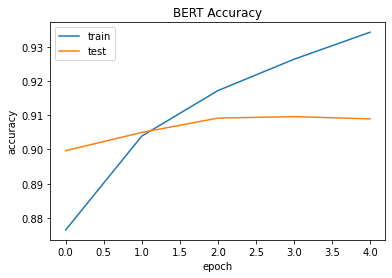

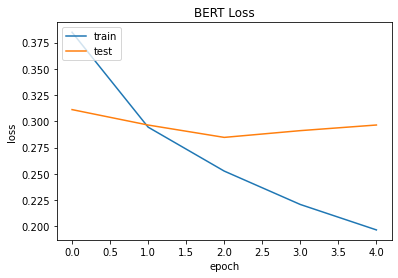

In [ ]:
def plot_train_hist(history, name):
    """
    This function plots the training history of the model.
    ---
    Input:
    history (object): history of the model according to fit() method.
    name (str): Name of the model
    
    Output:
    Two figures that show the history of the accuracy and history of the loss
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_train_hist(bert_model_history, "BERT")

In [ ]:
bert_model.evaluate(X_test, y_test)

2021-09-18 12:39:17,427 [WARNING] kashgari - Sequence length is None, will use the max embedding seq length, which is 512
2021-09-18 12:39:19,352 [DEBUG] kashgari - predict input shape (2, 54427, 512) x: 
(array([[ 101, 3204, 1119, ...,    0,    0,    0],
       [ 101,  704, 6349, ...,    0,    0,    0],
       [ 101, 5474, 2682, ...,    0,    0,    0],
       ...,
       [ 101, 7865, 7871, ...,    0,    0,    0],
       [ 101, 4707, 1957, ...,    0,    0,    0],
       [ 101,  924, 5397, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2021-09-18 12:59:05,737 [DEBUG] kashgari - predict output shape (54427, 12)
2021-09-18 12:59:05,782 [DEBUG] kashgari - predict output argmax: [1 4 0 ... 2 1 2]


              precision    recall  f1-score   support

         ACG     0.9024    0.9405    0.9210      6200
          娛樂     0.9531    0.8968    0.9241      8308
          情感     0.6667    0.5125    0.5795       160
          教育     0.9190    0.9300    0.9245      5672
          時事     0.8947    0.8980    0.8964      5717
          生活     0.9083    0.8867    0.8974      5074
          科技     0.8966    0.8986    0.8976      8569
          職場     0.6790    0.7775    0.7249       400
          藝文     0.5540    0.8500    0.6708       320
          議題     0.5272    0.4850    0.5052       200
          財經     0.8747    0.8721    0.8734      5825
          運動     0.9467    0.9564    0.9515      7982

    accuracy                         0.9070     54427
   macro avg     0.8102    0.8253    0.8139     54427
weighted avg     0.9085    0.9070    0.9073     54427



{'detail': {'ACG': {'f1-score': 0.9210235349865741,
   'precision': 0.9023522129371712,
   'recall': 0.9404838709677419,
   'support': 6200},
  'accuracy': 0.9070130633692837,
  'macro avg': {'f1-score': 0.813854816956732,
   'precision': 0.8101881283342983,
   'recall': 0.8253442328924606,
   'support': 54427},
  'weighted avg': {'f1-score': 0.9072972910763178,
   'precision': 0.9084536014849715,
   'recall': 0.9070130633692837,
   'support': 54427},
  '娛樂': {'f1-score': 0.9240977303733102,
   'precision': 0.9530570478383218,
   'recall': 0.8968464130958113,
   'support': 8308},
  '情感': {'f1-score': 0.5795053003533568,
   'precision': 0.6666666666666666,
   'recall': 0.5125,
   'support': 160},
  '教育': {'f1-score': 0.9244654749386612,
   'precision': 0.9189895470383276,
   'recall': 0.9300070521861777,
   'support': 5672},
  '時事': {'f1-score': 0.8963771278917503,
   'precision': 0.8947368421052632,
   'recall': 0.8980234388665383,
   'support': 5717},
  '生活': {'f1-score': 0.8973770818

In [ ]:
bert_model = BiGRU_Model.load_model('/content/drive/MyDrive/08文章辨識資料/Model/bert_model_ver4')

2021-09-18 13:15:16,741 [DEBUG] kashgari - ------------------------------------------------
2021-09-18 13:15:16,743 [DEBUG] kashgari - Loaded transformer model's vocab
2021-09-18 13:15:16,745 [DEBUG] kashgari - config_path       : /content/drive/MyDrive/08文章辨識資料/Model/BERT/bert_config.json
2021-09-18 13:15:16,747 [DEBUG] kashgari - vocab_path      : /content/drive/MyDrive/08文章辨識資料/Model/BERT/vocab.txt
2021-09-18 13:15:16,748 [DEBUG] kashgari - checkpoint_path : /content/drive/MyDrive/08文章辨識資料/Model/BERT/bert_model.ckpt
2021-09-18 13:15:16,751 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unuse

In [ ]:
outside_test = '哇！珍妮佛羅培茲！天后驚傳與A-Rod斬斷3年情 畢柏印地安人開幕戰先發　賽揚獎加持只加薪160萬 富邦勇士Q3暴衝逆轉險勝夢想家 最快明天例行賽封王 【中職開幕戰】總統蔡英文坐觀眾席看獅象大戰　今年統一冠軍戒長這樣 WTT決賽宰南韓2連冠　林昀儒鄭怡靜桌球混雙世界第1挺進第2周 尷尬了！巴西裁判情急場上撇尿　恰被錄影直擊「小瀑布」 世界第2梅迪耶夫服了　稱喬帥拿400周球王也沒問題 台灣拳擊職業化開步走　立勝盃全國拳擊聯賽今舉行 不強打疫苗不開放國際觀眾　IOC妥協全照日本意思 球員錦標賽第2回合　旅美潘政琮+8提前淘汰 昔日明星中鋒爛到被嫌！美媒爆料：湖人對賈索感到失望 F1法拉利新車紅配綠　引擎蓋廣告三條線尷尬了 紙風車《雨馬》總彩排　 「大隻馬」現身打破劇場框架 國片大爆發！去年票房市佔率破新高　蘇貞昌因李安一句話要效仿紐西蘭 【百萬低利貸】文化部啟動文創20億信貸　快速通關！最長5年利息補貼 故宮館藏走出櫥窗　躍上精品舞台！ 《九份往事》半世紀前風景躍然紙上　市長室迎賓區辦攝影展找回憶 【內閣人事】行政院宣布高流董事李靜慧接任文化部政次　盼推動藝文產業永續發展 街頭藝人悲歌——授權侵權的兩難（章忠信） 新北14位國家級工藝師聯展秀美技　珊瑚、毫芒雕刻嘆為觀止 兩廳院邀藝術家駐館！打造新世代劇場　#MeToo成創作起點 孟克不朽名畫《吶喊》暗藏密碼　「只有瘋子才畫得出來」 台灣最高地景藝術節梨山開幕　海拔2千賞部落美學 文大圖書館出版部萬本圖書清倉　50元銅板價拍賣！下殺不到一折 推動客語文化　客傳會與OTT合作發展客家電影 【獨家】文創設計師自創圖騰遭盜用4年　阿里山鄉長侵權在先竟嗆：要告去告 挑戰百萬年薪　國泰人壽招募儲備幹部 政院將討論「勞工職災保險及保護法」　一張表帶你看修法重點 「勞工職災保險法」有望周四政院拍板　4人以下公司皆須納保 2.2萬家資本額逾1億元企業當心！違反輪班、例假出勤　5/1起最重罰150萬元 全台43%女性　曾遇職場性騷  婦團調查　逾4成是上司老闆下手 中高齡就業推動小組委員　應加重中高齡受雇者代表人數 搶金融業金飯碗機會來了　合庫銀今年招募400人年薪上看75萬 台積電聯發科也受害！中資滲台雙倍年薪挖角數百工程師　智鈊、芯道負責人交保 趨勢科技啟動年度徵才計劃　暑期實習同步招生 加入「護國神山」機會來了！台積電校園徵才本周起跑 想捧金飯碗注意！　滙豐未來5年將在亞洲增聘逾5000人 【年後轉職】北市辦徵才釋468職缺　最高薪80K 微軟再徵百名研發人才　推動台灣成為全球技術研發重要據點 原民運19日羅東文化工場開幕　林姿妙視察防疫消毒作業 【藻礁攻防】立委赴大潭考察　經部環團交鋒！潘忠政：只盼開聽證會 募資85萬號召13義工　登山女神詹喬愉發起淨山 騎鐵馬打卡集章　抽5萬現金 有害空污物管制從72種減少到22種　環團籲環保署講清楚 【藻礁攻防】麥寮蓋天然氣接收站解大潭難題？環團力挺：護礁又護肺 【狼醫疑雲】熟識學長竟伸狼爪　專家：加害者利用信任感該被譴責 收性騷訊息「想摸妳奶」　黃捷：不排除提告 3千公尺高山上唯一女力救援　姚岱吟中士：從不放棄挑戰自我 國際奧委會挨批逃避人權議題　IOC主席：抵制北京冬奧無用 誇張！打了10年比賽才發現　印尼女排國手竟是男人 歐洲議會宣布歐盟為LGBTIQ自由區　波蘭仍推反同法案 【跨性別專題】尋找身分35年　跨女被當撞邪送中驅魔 監委之子副教授性侵女同志今出庭　被害女怒揭校方冷處理還讓升等 孫女為腦退化奶奶當全職看護　隔代照顧凸顯香港長照漏洞 一股力量推去撞牆！婦走路突踩空　就醫抓到｢魔神仔｣ 新北補助電動機車車方案出爐　汰舊換新最高補助1萬9 【遊彰化】跟著喵星人公仔　散步到扇形車庫 國軍首座軍服「直營店」今開幕　全台設15店面可用電商、APP下單 台東部落分享廚房首發團　吃貨縣長饒司機領路體驗魯凱族傳統美食 清明連假湧國旅潮　電商飯店住宿券5折起 Häagen-Dazs「蜜糖派對組」融化少女心　101忠狗、維尼熊造型初亮相 武漢肺炎疫情趨緩　桃園6家醫院調降自費篩檢費用 哈日族快換起來等解封！換5萬台幣多了6千元 星光花火、藍眼淚接力　離島旅遊旺季開跑航空業推限量優惠 全台最早、易抵達賞螢聖地！　花蓮平森園區螢光盛會浪漫開幕 宅經濟發酵 烘焙設備展備貨多2倍 帛琉旅遊泡泡　首發團最快2周成行 【春夏潮流筆記】卡其褲帥度超越兩世紀　英軍制服變身經典聖品 【越南美食】百年「飛機河粉」插旗台中新光　連續20天免費送千份炸雞 三芝三生步道吉野櫻綻放　粉白色花海妝點白色情人節 2019波爾多期酒　均價創近年新低　乾燥氣候孕育豐富果香　值得入手 超前部署新南向政策　清大今成立印度顧問團 政府帶頭，由社區來編寫家鄉英文學習教材 【退休再進修】都是在職生，年長的沒被給好臉色 防疫成果亮眼+反送中衝擊　港生個人申請來台大增1169人 全額獎學金5.4萬誘因大　這所私大強推VR、直播課！保證就業 一位新銳導演的心聲：擺脫電影輔導金的束縛 【全面治港】京官15日香港座談扮聽意見　特首：培養「愛國者」從教育著手 少子化衝擊！國中會考僅20.2萬人報名創新低　高中職9年少近20萬學生 范疇專欄：台灣可成就更高　但需要「雙語國力」 中國孔子學院遭歐美封殺　僑委會布局海外華語文據點 古琴梅庵派5代師東華大學開課　通識教育民眾皆可學 推動偏鄉小學科普教育 花蓮太陽能推廣中心成立 搞定小孩上學後的午睡！專家三個小Tips提醒 一代茶王不藏私　疫下開班　傳承港式奶茶文化 讓飼主與志工更了解毛孩　竹縣家畜所邀動物專家開課 耗水費怎麼算？王美花：循環水、傳產科技業計算方式持續評估 美白科技大躍進 研究發現NMN冰晶番茄有效對抗肌膚傷害 【3/17總疫報】世衛：建議繼續使用AZ疫苗　波蘭單日逾2.5萬例確診全國部分封鎖 考生看過來！新加坡研究：午睡能改善學習與記憶力 獨步全球！調查局4年磨一劍　檜木DNA資料庫讓山老鼠現形 台灣缺水拉警報　外資示警半導體、面板、PCB產業最受衝擊 台達電加入RE100組織　目標2030年全球廠辦100%使用再生能源 健康大數據有助精準防疫與公衛（陳保中、林先和、林亮瑜、魏志阜） 【政院組改】數位發展部最快下半年成立！首位部長唐鳳、郭耀煌呼聲高 研究：武肺疫情期間　醫護人員罹患憂鬱、焦慮及PTSD機率遠高於預期 【311十周年】福島核災十年後仍發現新放射物　料反應爐爆炸產生 【人助自助天助】從三個面向　把水找回來 研究：太陽愈來愈熱　未來地球將缺氧僅剩微生物能活 科技業投資新策略　打造台灣科技產業新廊道 熟女就醫堅持穿雨衣、戴手套　原來是「焦慮症」作祟 【名采】楊索專欄：削廋的靈魂 【名采】張惠菁專欄：家的故事 年輕歌手離去後　要小心模仿效應 兩性作家分析「4種關係最容易讓男人外遇」　網崩潰：太誘人 權權療心室：照顧者奢想的禮物 重度憂鬱自殺有年輕、學子化趨勢　專家：留意這9大症狀 假老友來電「生病需要用錢」　8旬老婦險被騙走70萬養老金 【獨家】機組員檢疫期縮短為5天上周五悄悄上路　違者重罰30萬元 凝聚力量續爭港民主　流亡港人發起《2021香港約章》 內戰10年仍未撼動敘利亞政府　8旬老翁戰火中失去13子女 《紐時》讚台「防疫綠洲」　今年成長率看好　估達4.6% 【港版美麗島】民主派47人保釋案覆核　多3人獲保釋2人須還押 【獨家】聯亞疫苗二期試驗已完成2千人收案　預計周日達標 印尼預告將炸毀非法捕魚外國漁船　有台灣漁船遭扣留調查 屏東人行道驚見男屍　有血跡！竟是鬼祟男打死的 爆炸瞬間曝光！北市疑酒店糾紛尋仇　男丟震撼彈釀1傷 檢察官打擊環保犯罪！卜蜂汙泥、化骨水棄置　追緝財團復原環境 驚！刑事局隊長涉洩密運毒案偵查計畫　檢調搜索複訊10萬交保 桃園農會選舉涉買票　檢調送辦落選人10萬元交保 【遊覽車撞山】死傷慘重主因　資深駕駛研判：疑操作不當與車體強度不足 印度外匯存底躍全球第四高央行囤積美元是主因。 瑞銀預估 大陸今年首季GDP年增率逼近20% 疫情效應全球爆發嬰兒荒，法國出生率探二戰以來新低，大陸新生兒減少15 %。 財管服務有溫度　中信銀連6年獲獎 他全額貸84期買BMW重機　專家曝這樣做免借錢合法騎回家 阿爾發機器人理財　獲頒ISO 27001資訊安全認證 年輕股民最愛金融　玉山金躍存股榜首 年輕人存股排名！金融股打趴台積電　0056居第2名 台股操作　4招耐震心法  最高原則分散風險　善用ETF資產配置 賴正鎰：打房惡果回推購屋族　投客口袋夠深繼續炒 謝哲青推薦理財書　出版社出奇招「買就送1美元發財金」 Fed維持利率不變美股全面翻紅　道瓊漲逾189點創新高 不甩債市風暴！Fed每月購債3兆未加碼　維持零利率 【股市內圈咖啡杯怎挑】以美國10年期公債殖利率看股價 市場錢多到像玩假鈔？戴利歐：布局非美元資產吧 替大戶藏黑盒子搶股　金管會要證交所1個月提檢討報告 投資政策紅利　投信：聚焦中國內部大循環 股市面臨利空測試　類股輪動投資人勿慌 何時完成100%收購中壽？開發金：觀察市況與價格再決定 碩辣椒宣布台日合作　攜手Sparkleling開發美少女系手遊 日漫改編RPG手遊　《勇者鬥惡龍 達伊的大冒險》今年上線 Cosplay女達人「縫」出一片天　考證照開工作坊商機大熱 漫畫圈恐慌！《CCC創作集》補助傳喊停　立委要求續撥以打造台版鬼滅之刃 「向小學全速前進！」漫迷戶外唱蘿莉控聖歌　台大男批「噁宅」！2派網友戰翻 《名偵探柯南》4月全球同步登銀幕　聲優5國語片頭較勁 看好Switch銷量　任天堂喊再創高  新年度遊戲軟體要賣2.5億套 赤燭網路商店上線　返校還願都可玩 遊戲直播侮辱猶太人　熱火雷納德禁賽中加罰140萬 中國人大提議「禁止半夜打電玩」　微博炸裂：可以先管通宵加班嗎？ 科幻射擊新作《先遣戰士》夯　體驗版一周創200萬下載 《要塞英雄》找《糖豆人》助陣！　EPIC宣布收購遊戲開發商Tonic Games MEGA戰鬥哥爆紅十周年　經典港都再現！How哥被約出讚：永遠的英雄 《薩爾達傳說 天空之劍》HD重製版6月上市　支援體感遊玩'
outside_test = [list(line) for line in outside_test.replace('\u3000', '').split(' ')]

In [ ]:
outside_test_output=bert_model.predict(outside_test,multi_label_threshold=0.5)

2021-09-18 13:15:45,895 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 42
2021-09-18 13:15:45,905 [DEBUG] kashgari - predict input shape (2, 171, 42) x: 
(array([[ 101, 1505, 8013, ...,    0,    0,    0],
       [ 101, 4525, 3377, ...,    0,    0,    0],
       [ 101, 2168, 6930, ...,    0,    0,    0],
       ...,
       [ 101,  100,  100, ...,    0,    0,    0],
       [ 101,  517, 5958, ...,    0,    0,    0],
       [ 101, 1921, 4958, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2021-09-18 13:15:51,782 [DEBUG] kashgari - predict output shape (171, 12)
2021-09-18 13:15:51,785 [DEBUG] kashgari - predict output argmax: [1 2 2 2 2 2 5 2 2 5 2 2 5 1 1 1 4 1 7 4 1 7 6 1 7 6 7 7 4 3 4 4 5 1 1 4 4
 0 0 6 0 4 0 7 7 2 3 4 7 6 1 2 5 2 5

In [ ]:
bert_model_result = bert_model.predict(X_test, multi_label_threshold=0.5)

In [ ]:
X_output = ["".join(txt) for txt in X_test]
output_df = pd.DataFrame({"content":X_output,"input_id":y_test,"output_id":bert_model_result})
output_df[output_df["input_id"]!=output_df["output_id"]]

In [ ]:
# 游宏宇給的假資料
X_output = ["".join(txt) for txt in outside_test]
output_df = pd.DataFrame({"id":outside_test_output, "content":X_output})
output_df.head()
output_df.to_csv("/content/drive/MyDrive/08文章辨識資料/Output/假資料.csv")

# X_test output
#X_output = ["".join(txt) for txt in X_test]
#output_df = pd.DataFrame({"content":X_output,"output_id":bert_model_result})
#output_df.to_csv("/content/drive/MyDrive/08文章辨識資料/test_output.csv")